# EEGDash example for eyes open vs. closed classification

The code below provides an example of using the *EEGDash* library in combination with PyTorch to develop a deep learning model for analyzing EEG data, specifically for eyes open vs. closed classification in a single subject.

1. **Data Retrieval Using EEGDash**: An instance of *EEGDashDataset* is created to search and retrieve an EEG dataset. At this step, only the metadata is transferred.

2. **Data Preprocessing Using BrainDecode**: This process preprocesses EEG data using Braindecode by reannotating events, selecting specific channels, resampling, filtering, and extracting 2-second epochs, ensuring balanced eyes-open and eyes-closed data for analysis.

3. **Creating train and testing sets**: The dataset is split into training (80%) and testing (20%) sets with balanced labels, converted into PyTorch tensors, and wrapped in DataLoader objects for efficient mini-batch training.

4. **Model Definition**: The model is a shallow convolutional neural network (ShallowFBCSPNet) with 24 input channels (EEG channels), 2 output classes (eyes-open and eyes-closed).

5. **Model Training and Evaluation Process**: This section trains the neural network, normalizes input data, computes cross-entropy loss, updates model parameters, and evaluates classication accuracy over six epochs.



## Data Retrieval Using EEGDash

First we find one resting state dataset. This dataset contains both eyes open and eyes closed data.

In [1]:
from eegdash import EEGDashDataset

ds_eoec = EEGDashDataset(
    {"dataset": "ds005514", "task": "RestingState", "subject": "NDARDB033FW5"}
)

## Data Preprocessing Using Braindecode

[BrainDecode](https://braindecode.org/stable/install/install.html) is a specialized library for preprocessing EEG and MEG data. In this dataset, there are two key events in the continuous data: **instructed_toCloseEyes**, marking the start of a 40-second eyes-closed period, and **instructed_toOpenEyes**, indicating the start of a 20-second eyes-open period.

For the eyes-closed event, we extract 14 seconds of data from 15 to 29 seconds after the event onset. Similarly, for the eyes-open event, we extract data from 5 to 19 seconds after the event onset. This ensures an equal amount of data for both conditions. The event extraction is handled by the custom function **hbn_ec_ec_reannotation**.

Next, we apply four preprocessing steps in Braindecode:
1.	**Reannotation** of event markers using hbn_ec_ec_reannotation().
2.	**Selection** of 24 specific EEG channels from the original 128.
3.	**Resampling** the EEG data to a frequency of 128 Hz.
4.	**Filtering** the EEG signals to retain frequencies between 1 Hz and 55 Hz.

When calling the **preprocess** function, the data is retrieved from the remote repository.

Finally, we use **create_windows_from_events** to extract 2-second epochs from the data. These epochs serve as the dataset samples. At this stage, each sample is automatically labeled with the corresponding event type (eyes-open or eyes-closed). windows_ds is a PyTorch dataset, and when queried, it returns labels for eyes-open and eyes-closed (assigned as labels 0 and 1, corresponding to their respective event markers).

In [2]:
from braindecode.preprocessing import (
    preprocess,
    Preprocessor,
    create_windows_from_events,
)
import numpy as np
import mne
import warnings

warnings.simplefilter("ignore", category=RuntimeWarning)


class hbn_ec_ec_reannotation(Preprocessor):
    def __init__(self):
        super().__init__(
            fn=self.transform, apply_on_array=False
        )  # Pass the transform method as the function

    def transform(self, raw):  # Changed from 'apply' to 'transform'
        # Create events array from annotations
        events, event_id = mne.events_from_annotations(raw)

        print(event_id)

        # Create new events array for 2-second segments
        new_events = []
        sfreq = raw.info["sfreq"]
        for event in events[events[:, 2] == event_id["instructed_toCloseEyes"]]:
            # For each original event, create events every 2 seconds from 15s to 29s after
            start_times = event[0] + np.arange(15, 29, 2) * sfreq
            new_events.extend([[int(t), 0, 1] for t in start_times])

        for event in events[events[:, 2] == event_id["instructed_toOpenEyes"]]:
            # For each original event, create events every 2 seconds from 5s to 19s after
            start_times = event[0] + np.arange(5, 19, 2) * sfreq
            new_events.extend([[int(t), 0, 2] for t in start_times])

        # replace events in raw
        new_events = np.array(new_events)
        annot_from_events = mne.annotations_from_events(
            events=new_events,
            event_desc={1: "eyes_closed", 2: "eyes_open"},
            sfreq=raw.info["sfreq"],
        )
        raw.set_annotations(annot_from_events)
        return raw


# BrainDecode preprocessors
preprocessors = [
    hbn_ec_ec_reannotation(),
    Preprocessor(
        "pick_channels",
        ch_names=[
            "E22",
            "E9",
            "E33",
            "E24",
            "E11",
            "E124",
            "E122",
            "E29",
            "E6",
            "E111",
            "E45",
            "E36",
            "E104",
            "E108",
            "E42",
            "E55",
            "E93",
            "E58",
            "E52",
            "E62",
            "E92",
            "E96",
            "E70",
            "Cz",
        ],
    ),
    Preprocessor("resample", sfreq=128),
    Preprocessor("filter", l_freq=1, h_freq=55),
]
preprocess(ds_eoec, preprocessors)

# Extract 2-second segments
windows_ds = create_windows_from_events(
    ds_eoec,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=int(2 * ds_eoec.datasets[0].raw.info["sfreq"]),
    preload=True,
)

Used Annotations descriptions: [np.str_('boundary'), np.str_('break cnt'), np.str_('instructed_toCloseEyes'), np.str_('instructed_toOpenEyes'), np.str_('resting_start')]
{np.str_('boundary'): 1, np.str_('break cnt'): 2, np.str_('instructed_toCloseEyes'): 3, np.str_('instructed_toOpenEyes'): 4, np.str_('resting_start'): 5}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 59.50 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Plotting a Single Channel for One Sample

It’s always a good practice to verify that the data has been properly loaded and processed. Here, we plot a single channel from one sample to ensure the signal is present and looks as expected.

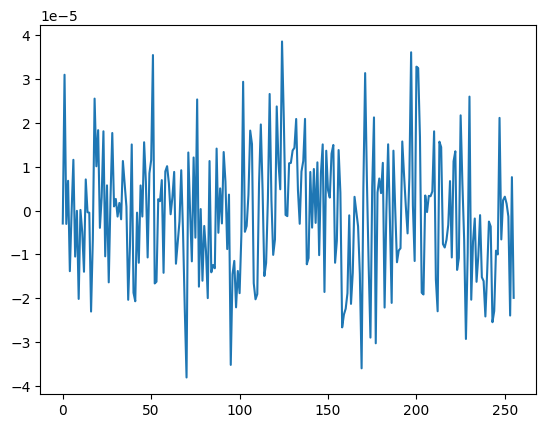

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(windows_ds[2][0][0, :].transpose())  # first channel of first epoch
plt.show()

## Features

In [4]:
from eegdash import features
from eegdash.features import extract_features
from functools import partial

sfreq = windows_ds.datasets[0].raw.info["sfreq"]
filter_freqs = dict(windows_ds.datasets[0].raw_preproc_kwargs)["filter"]
features_dict = {
    "sig": features.FeatureExtractor(
        {
            "mean": features.signal_mean,
            "var": features.signal_variance,
            "std": features.signal_std,
            "skew": features.signal_skewness,
            "kurt": features.signal_kurtosis,
            "rms": features.signal_root_mean_square,
            "ptp": features.signal_peak_to_peak,
            "quan.1": partial(features.signal_quantile, q=0.1),
            "quan.9": partial(features.signal_quantile, q=0.9),
            "line_len": features.signal_line_length,
            "zero_x": features.signal_zero_crossings,
        },
    ),
    "spec": features.SpectralFeatureExtractor(
        {
            "rtot_power": features.spectral_root_total_power,
            "band_power": partial(
                features.spectral_bands_power,
                bands={
                    "theta": (4.5, 8),
                    "alpha": (8, 12),
                    "beta": (12, 30),
                },
            ),
            0: features.NormalizedSpectralFeatureExtractor(
                {
                    "moment": features.spectral_moment,
                    "entropy": features.spectral_entropy,
                    "edge": partial(features.spectral_edge, edge=0.9),
                },
            ),
            1: features.DBSpectralFeatureExtractor(
                {
                    "slope": features.spectral_slope,
                },
            ),
        },
        fs=sfreq,
        f_min=filter_freqs["l_freq"],
        f_max=filter_freqs["h_freq"],
        nperseg=2 * sfreq,
        noverlap=int(1.5 * sfreq),
    ),
}

features_ds = extract_features(windows_ds, features_dict, batch_size=512)

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


In [5]:
features_ds.to_dataframe(include_crop_inds=True)

,i_dataset,i_window_in_trial,i_start_in_trial,i_stop_in_trial,sig_mean_E22,sig_mean_E9,sig_mean_E33,sig_mean_E24,sig_mean_E11,sig_mean_E124,...,spec_slope_int_E42,spec_slope_int_E55,spec_slope_int_E93,spec_slope_int_E58,spec_slope_int_E52,spec_slope_int_E62,spec_slope_int_E92,spec_slope_int_E96,spec_slope_int_E70,spec_slope_int_Cz
0,0,0,8092,8348,5.647381e-07,-2.509246e-06,8.135321e-06,1.344657e-06,3.320702e-08,-1.906805e-06,...,-102.550099,-112.708475,-116.428728,-103.793443,-109.095191,-103.952144,-111.006049,-104.675563,-102.440827,-150.0
1,0,0,8348,8604,1.130721e-06,1.416919e-07,-6.768836e-07,1.253810e-06,4.680605e-07,4.802966e-07,...,-109.939679,-117.077513,-113.602566,-104.561765,-106.023037,-107.080705,-109.806066,-104.344682,-104.799112,-150.0
2,0,0,8604,8860,-8.737620e-07,2.451451e-07,3.854794e-07,1.361636e-07,2.133896e-07,-3.657373e-07,...,-107.551500,-116.664466,-112.225315,-109.640783,-104.855979,-109.204332,-111.056286,-106.110174,-110.122209,-150.0
3,0,0,8860,9116,3.482372e-07,-5.419446e-07,-7.257668e-08,-2.957054e-07,-6.512602e-07,3.577126e-07,...,-111.997522,-113.929940,-110.304607,-107.195040,-109.591409,-103.861653,-106.993096,-102.303912,-103.017478,-150.0
4,0,0,9116,9372,1.078094e-06,2.234204e-06,8.322080e-07,2.739075e-07,5.221804e-07,4.892659e-07,...,-106.720845,-115.076340,-109.082729,-105.041037,-105.644516,-106.383149,-106.617371,-105.062853,-104.805347,-150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,0,43163,43419,2.604641e-06,2.696607e-06,3.207271e-07,1.414571e-06,8.683887e-07,6.164495e-07,...,-101.826239,-104.721329,-102.156633,-101.039169,-99.035500,-97.832437,-96.538766,-98.014541,-100.639055,-150.0
66,0,0,43419,43675,-1.158709e-06,-9.353611e-07,6.243006e-07,-4.668101e-07,-2.474646e-07,8.406842e-08,...,-111.331055,-114.300917,-115.154808,-97.786847,-103.718403,-102.189734,-106.480431,-98.017596,-98.486937,-150.0
67,0,0,43675,43931,9.350503e-07,7.273056e-07,-3.974258e-07,-4.191231e-07,-5.750178e-08,-3.900544e-07,...,-104.924468,-116.952987,-111.992012,-97.748327,-100.684413,-107.478499,-112.420521,-102.707378,-101.104331,-150.0
68,0,0,43931,44187,-1.334396e-04,-4.969487e-05,-2.251352e-06,-4.908819e-06,-1.746263e-05,-9.156347e-06,...,-104.102473,-110.698731,-110.934666,-100.587624,-102.646614,-100.844665,-103.707894,-95.452641,-99.766156,-150.0


In [6]:
features_ds.fillna(0)
features_ds.zscore(eps=1e-7)

In [7]:
features_ds.to_dataframe(include_target=True)

,sig_mean_E22,sig_mean_E9,sig_mean_E33,sig_mean_E24,sig_mean_E11,sig_mean_E124,sig_mean_E122,sig_mean_E29,sig_mean_E6,sig_mean_E111,...,spec_slope_int_E55,spec_slope_int_E93,spec_slope_int_E58,spec_slope_int_E52,spec_slope_int_E62,spec_slope_int_E92,spec_slope_int_E96,spec_slope_int_E70,spec_slope_int_Cz,target
0,0.026538,-0.262187,2.919854,0.722139,0.025242,-0.940292,-1.824341,1.464295,-0.012576,-0.269156,...,-0.076765,-1.885502,-0.579490,-1.409001,0.012831,-1.395235,-0.920786,-0.362538,0.0,1
1,0.050815,0.064840,-0.319069,0.671190,0.155615,0.301339,-0.114326,0.684043,-0.029703,0.133713,...,-1.313005,-1.347661,-0.728354,-0.717287,-0.848564,-1.163734,-0.851870,-0.956851,0.0,1
2,-0.035166,0.077603,0.071402,0.044395,0.079263,-0.138719,0.009489,0.083306,0.509602,-0.413178,...,-1.196131,-1.085559,-1.712426,-0.454518,-1.433267,-1.404927,-1.219589,-2.298327,0.0,1
3,0.017251,-0.019495,-0.096956,-0.197805,-0.179967,0.237578,0.069691,-0.312527,-0.548498,0.183766,...,-0.422384,-0.720033,-1.238558,-1.520727,0.037746,-0.621054,-0.426815,-0.507860,0.0,1
4,0.048558,0.322979,0.235597,0.121644,0.171841,0.306004,0.918088,-0.565982,-0.439382,0.644879,...,-0.746763,-0.487501,-0.821214,-0.632061,-0.656504,-0.548569,-1.001451,-0.958422,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.114038,0.380022,0.047603,0.761347,0.275637,0.372158,0.338585,0.531540,0.083321,-0.183340,...,2.183237,0.830590,-0.045842,0.855997,1.697784,1.395802,0.466582,0.091527,0.0,0
66,-0.047388,-0.068028,0.159181,-0.293764,-0.058905,0.095244,0.265609,0.223890,0.080874,0.827962,...,-0.527354,-1.643065,0.584303,-0.198386,0.498079,-0.522150,0.465945,0.633883,0.0,0
67,0.042422,0.137083,-0.216354,-0.267020,-0.001953,-0.151367,-0.319625,-0.800014,-0.287558,-0.755622,...,-1.277770,-1.041160,0.591766,0.484735,-0.958089,-1.668116,-0.510850,-0.025727,0.0,0
68,-5.721500,-6.083144,-0.897765,-2.784919,-5.220163,-4.711083,-0.857839,-1.306562,-4.082123,-2.983083,...,0.491902,-0.839939,0.041646,0.042934,0.868420,0.012729,1.000178,0.311507,0.0,0


## Creating training and test sets

The code below creates a training and test set. We first split the data into training and test sets using the **train_test_split** function from the **sklearn** library. We then create a **TensorDataset** for the training and test sets.

1.	**Set Random Seed** – The random seed is fixed using torch.manual_seed(random_state) to ensure reproducibility in dataset splitting and model training.
2.	**Extract Labels from the Dataset** – Labels (eye-open or eye-closed events) are extracted from windows_ds, stored as a NumPy array, and printed for verification.
3.	**Split Dataset into Train and Test Sets** – The dataset is split into training (80%) and testing (20%) subsets using train_test_split(), ensuring balanced stratification based on the extracted labels. Stratification means that we have as many eyes-open and eyes-closed samples in the training and testing sets.
4.	**Convert Data to PyTorch Tensors** – The selected training and testing samples are converted into FloatTensor for input features and LongTensor for labels, making them compatible with PyTorch models.
5.	**Create DataLoaders** – The datasets are wrapped in PyTorch DataLoader objects with a batch size of 10, enabling efficient mini-batch training and shuffling.


In [8]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Set random seed for reproducibility
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

# Extract labels from the dataset
eo_ec = np.array([ds[1] for ds in features_ds]).ravel()  # check labels
print("labels: ", eo_ec)

# Get balanced indices for male and female subjects
train_indices, test_indices = train_test_split(
    range(len(features_ds)), test_size=0.2, stratify=eo_ec, random_state=random_state
)

# Convert the data to tensors
X_train = torch.FloatTensor(
    np.array([features_ds[i][0] for i in train_indices])
)  # Convert list of arrays to single tensor
X_test = torch.FloatTensor(
    np.array([features_ds[i][0] for i in test_indices])
)  # Convert list of arrays to single tensor
y_train = torch.LongTensor(eo_ec[train_indices])  # Convert targets to tensor
y_test = torch.LongTensor(eo_ec[test_indices])  # Convert targets to tensor
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

# Create data loaders for training and testing (batch size 10)
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=True)

# Print shapes and sizes to verify split
print(
    f"Shape of data {X_train.shape} number of samples - Train: {len(train_loader)}, Test: {len(test_loader)}"
)
print(
    f"Eyes-Open/Eyes-Closed balance, train: {np.mean(eo_ec[train_indices]):.2f}, test: {np.mean(eo_ec[test_indices]):.2f}"
)

labels:  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Shape of data torch.Size([56, 480]) number of samples - Train: 6, Test: 2
Eyes-Open/Eyes-Closed balance, train: 0.50, test: 0.50


# Check labels

It is good practice to verify the labels and ensure the random seed is functioning correctly. If all labels are 0s (eyes closed) or 1s (eyes open), it could indicate an issue with data loading or stratification, requiring further investigation.

In [9]:
# Visualize a batch of target labels
dataiter = iter(train_loader)
first_item, label = dataiter.__next__()
label

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0])

# Create model

The model is a shallow convolutional neural network (ShallowFBCSPNet) with 24 input channels (EEG channels), 2 output classes (eyes-open and eyes-closed), and an input window size of 256 samples (2 seconds of EEG data). 

In [10]:
import torch
from torch import nn
from torchinfo import summary

torch.manual_seed(random_state)
# MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features_ds.datasets[0].n_features, 100),
    nn.Linear(100, 100),
    nn.Linear(100, 100),
    nn.Linear(100, 2),
)

summary(model, input_size=first_item.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [10, 2]                   --
├─Flatten: 1-1                           [10, 480]                 --
├─Linear: 1-2                            [10, 100]                 48,100
├─Linear: 1-3                            [10, 100]                 10,100
├─Linear: 1-4                            [10, 100]                 10,100
├─Linear: 1-5                            [10, 2]                   202
Total params: 68,502
Trainable params: 68,502
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.69
Input size (MB): 0.02
Forward/backward pass size (MB): 0.02
Params size (MB): 0.27
Estimated Total Size (MB): 0.32

# Model Training and Evaluation Process

This section trains the neural network using the Adamax optimizer, normalizes input data, computes cross-entropy loss, updates model parameters, and tracks accuracy across six epochs.

1. **Set Up Optimizer and Learning Rate Scheduler** – The `Adamax` optimizer initializes with a learning rate of 0.002 and weight decay of 0.001 for regularization. An `ExponentialLR` scheduler with a decay factor of 1 keeps the learning rate constant.  

2. **Allocate Model to Device** – The model moves to the specified device (CPU, GPU, or MPS for Mac silicon) to optimize computation efficiency.  

3. **Normalize Input Data** – The `normalize_data` function standardizes input data by subtracting the mean and dividing by the standard deviation along the time dimension before transferring it to the appropriate device.  

4. **Evaluates Classification Accuracy Over Six Epochs** – The training loop iterates through data batches with the model in training mode. It normalizes inputs, computes predictions, calculates cross-entropy loss, performs backpropagation, updates model parameters, and steps the learning rate scheduler. It tracks correct predictions to compute accuracy.  

5. **Evaluate on Test Data** – After each epoch, the model runs in evaluation mode on the test set. It computes predictions on normalized data and calculates test accuracy by comparing outputs with actual labels.  

In [11]:
from torch.nn import functional as F

optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = model.to(device=device)  # move the model parameters to CPU/GPU
epochs = 6

for e in range(epochs):
    # training
    correct_train = 0
    for t, (x, y) in enumerate(train_loader):
        model.train()  # put model to training mode
        scores = model(x)
        y = y.to(device=device, dtype=torch.long)
        _, preds = scores.max(1)
        correct_train += (preds == y).sum() / len(dataset_train)

        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Validation
    correct_test = 0
    for t, (x, y) in enumerate(test_loader):
        model.eval()  # put model to testing mode
        scores = model(x)
        y = y.to(device=device, dtype=torch.long)
        _, preds = scores.max(1)
        correct_test += (preds == y).sum() / len(dataset_test)

    # Reporting
    print(
        f"Epoch {e}, Train accuracy: {correct_train:.2f}, Test accuracy: {correct_test:.2f}"
    )

Epoch 0, Train accuracy: 0.62, Test accuracy: 0.79
Epoch 1, Train accuracy: 0.84, Test accuracy: 0.86
Epoch 2, Train accuracy: 0.86, Test accuracy: 0.79
Epoch 3, Train accuracy: 0.88, Test accuracy: 0.79
Epoch 4, Train accuracy: 0.88, Test accuracy: 0.79
Epoch 5, Train accuracy: 0.88, Test accuracy: 0.71


In [12]:
from lightgbm import LGBMClassifier

data_df = features_ds.to_dataframe(include_target=True)
X_train, y_train = (
    data_df.drop("target", axis=1).iloc[train_indices],
    data_df.loc[train_indices, "target"],
)
X_val, y_val = (
    data_df.drop("target", axis=1).iloc[test_indices],
    data_df.loc[test_indices, "target"],
)

clf = LGBMClassifier()
clf.fit(X_train, y_train)

y_hat_train = clf.predict(X_train)
correct_train = (y_train == y_hat_train).mean()
y_hat_val = clf.predict(X_val)
correct_val = (y_val == y_hat_val).mean()
print(f"Train accuracy: {correct_train:.2f}, Validation accuracy: {correct_val:.2f}\n")

[LightGBM] [Info] Number of positive: 28, number of negative: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9205
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 460
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

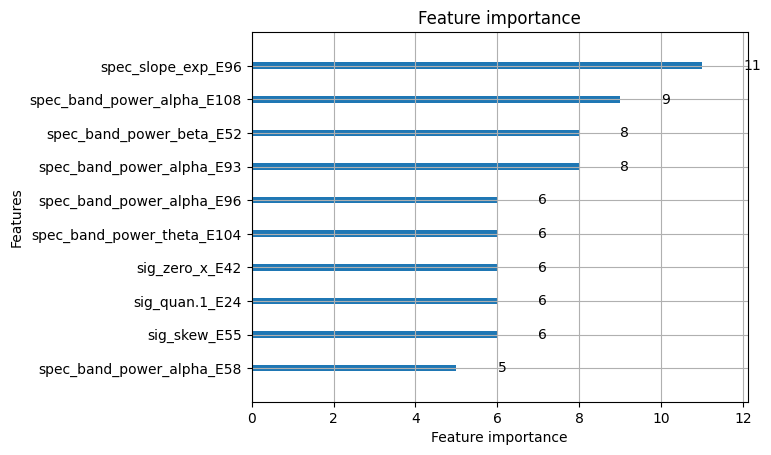

In [13]:
from lightgbm import plot_importance

plot_importance(clf, importance_type="split", max_num_features=10)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

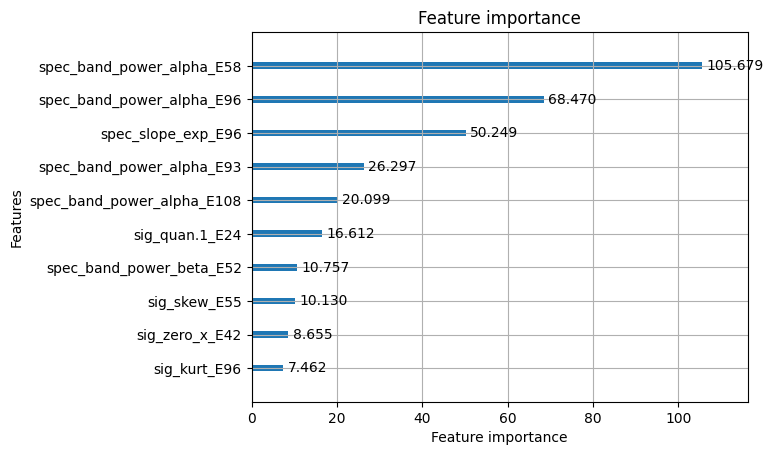

In [14]:
plot_importance(clf, importance_type="gain", max_num_features=10)